In [25]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# **Extracting and Preprocesing Training and Test Data** 

In [26]:
#get training and test data, transform into numpy arrays 
train_dataframe = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test_dataframe = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

#separating labels and input
y_train = train_dataframe.iloc[:, 0]
x_train = train_dataframe.iloc[:, 1:]
#getting test input
x_test = test_dataframe.iloc[:, 0:]

#turning df's to numpy arrs
y_train_arr = y_train.to_numpy()
#dividing by 255 to not get such large inputs
x_train_arr = x_train.to_numpy()/ 255.0
x_test_arr = x_test.to_numpy()/ 255.0

# **Defining Activations** 

In [27]:
#Activation for 1st hidden layer
def ReLU(x):
    return np.maximum(0, x)

#element-wise operation on input array
#produces an array of softmaxed probabilities
def softmax(z):
    #balancing for maximum in array
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

#ReLU derivative
def d_ReLU(x):
    return (x>0).astype(np.float32)

# **Helper Functions** 

In [29]:
#store list of weights for each layer
def init_params():
    params = {}
    params["W1"] = np.random.randn(16, 784) * 0.1
    params["b1"] = np.zeros((1, 16))
    params["W2"] = np.random.randn(10, 16) * 0.1
    params["b2"] = np.zeros((1, 10))
    return params

#generates a batch_size x num_classes matrix of one-hot encoded labels
def one_hot_encode(Y):
    num_classes = 10
    one_hot_y = np.zeros((Y.size, num_classes))
    one_hot_y[np.arange(Y.size), Y] = 1
    return one_hot_y

#choose random test image and get model's prediction
def show_random_image(params, X):
    i = np.random.randint(X.shape[0])
    random_image = X[i]
    pixels = random_image.reshape((28, 28))
    plt.imshow(pixels, cmap='gray')
    plt.show()
    x_sample = random_image.reshape(1, -1)   # (1,784)
    A2, _ = forward_prop(params, x_sample)   # forward pass
    pred_label = get_labels(A2)
    print("Prediction: ", pred_label[0])

def get_labels(predictions):
    #predictions: rows - batch_size, columns - probabilities (10 classes)
    # axis=1 means taking the max element across column axis
    # result will be batch_sizex1 matrix
    return np.argmax(predictions, axis=1)



def shuffle_data(X, Y):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    return X[indices], Y[indices]

# **Model Functionality & Training Loop** 

In [31]:
#propagating features to get intermediate parameters
def forward_prop(params, X):
    W1, b1 = params["W1"], params["b1"]
    W2, b2 = params["W2"], params["b2"]
    
    Z1 = X@W1.T+b1
    A1 = ReLU(Z1)
    Z2 = A1@W2.T+b2
    A2 = softmax(Z2)
    #all values in cache have dimensions batch_size x neurons
    cache = {"Z1": Z1,
            "Z2": Z2,
            "A1": A1,
            "A2": A2}
    return A2, cache




#returns param gradients(as vectors)
def back_prop(params, cache, X, Y, batch_size):
    Z1, A1 = cache["Z1"], cache["A1"]
    Z2, A2 = cache["Z2"], cache["A2"]
    W2 = params["W2"]
    Y_one_hot = one_hot_encode(Y)
    dZ2 = A2 - Y_one_hot #softmax with cross entropy (result is a batch_size x 10 matrix)
    dW2 = 1/batch_size * dZ2.T@A1 #returns 10x16 matrix
    db2 = 1/batch_size *np.sum(dZ2, axis=0, keepdims=True) #gives 1x10 matrix
    dZ1 = dZ2@W2*d_ReLU(Z1) #gives batch_size x 16 matrix
    dW1 = 1/batch_size* dZ1.T@X #16 x batch_size dot batch_sizex784 gives 16x784
    db1 = 1/batch_size *np.sum(dZ1, axis=0, keepdims=True) #gives 1x16 matrix
    grads = {"dW1":dW1,
            "db1": db1,
            "dW2": dW2,
            "db2": db2}
    
    return grads
    
def gradient_descent(params, grads, alpha, L):
    for l in range(1, L+1):
        params[f"W{l}"] -= grads[f"dW{l}"] * alpha
        params[f"b{l}"] -= grads[f"db{l}"] * alpha
    

def training(params, X_train, Y_train, alpha, batch_size, epochs):
    W1, b1 = params["W1"], params["b1"]
    W2, b2 = params["W2"], params["b2"]
    overall_acc = 0.0
    m = len(X_train)
    num_batches = m//batch_size
    for i in range(epochs):
        epoch_acc = 0.0
        X_train, Y_train = shuffle_data(X_train, Y_train)
        correct, total = 0, 0
        for j in range(0, m, batch_size):
            X_batch = X_train[j:j+batch_size, :]
            Y_batch = Y_train[j:j+batch_size]
            #get prediction and cache values
            A2, cache = forward_prop(params, X_batch)
            grads = back_prop(params, cache, X_batch, Y_batch, batch_size)
            #for every layer's parameter list, perform gradient descent
            gradient_descent(params, grads, alpha, 1) #1 means 1 hidden layer
            pred = get_labels(A2)
            correct += (pred==Y_batch).sum()
            total+=len(Y_batch)
        epoch_acc=correct/total
        overall_acc+=epoch_acc
        print(f"Epoch {i+1}/{epochs} - Accuracy: {epoch_acc*100:.2f}%")
    overall_acc/=epochs
    print(f"Overall model accuracy: {(overall_acc)*100}%") 

params = init_params()
alpha = 0.5 #quite high for most purposes, works for a relatively small task
#batch size 64, 937 batches per epoch, 20 epochs
batch_size = 64
epochs = 20



# **Model Learning & Classifying Random Images** 

Epoch 1/20 - Accuracy: 92.10%
Epoch 2/20 - Accuracy: 92.11%
Epoch 3/20 - Accuracy: 92.28%
Epoch 4/20 - Accuracy: 92.31%
Epoch 5/20 - Accuracy: 92.33%
Epoch 6/20 - Accuracy: 92.38%
Epoch 7/20 - Accuracy: 92.53%
Epoch 8/20 - Accuracy: 92.50%
Epoch 9/20 - Accuracy: 92.65%
Epoch 10/20 - Accuracy: 92.61%
Epoch 11/20 - Accuracy: 92.68%
Epoch 12/20 - Accuracy: 92.69%
Epoch 13/20 - Accuracy: 92.81%
Epoch 14/20 - Accuracy: 92.75%
Epoch 15/20 - Accuracy: 92.84%
Epoch 16/20 - Accuracy: 92.88%
Epoch 17/20 - Accuracy: 92.93%
Epoch 18/20 - Accuracy: 92.89%
Epoch 19/20 - Accuracy: 92.98%
Epoch 20/20 - Accuracy: 92.98%
Overall model accuracy: 92.61130952380952%


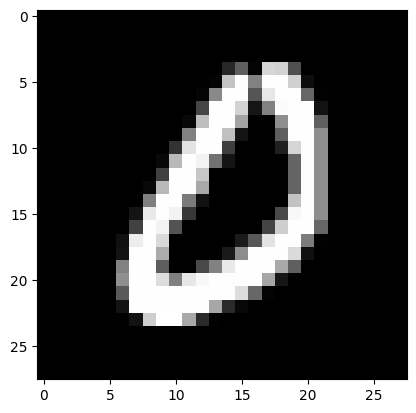

Prediction:  0


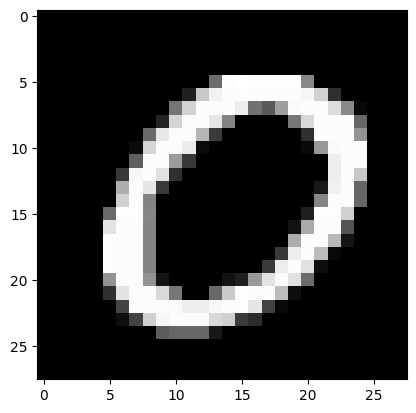

Prediction:  0


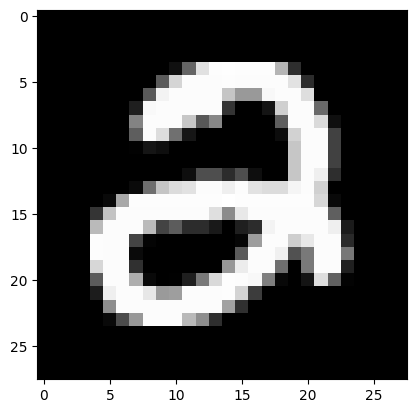

Prediction:  2


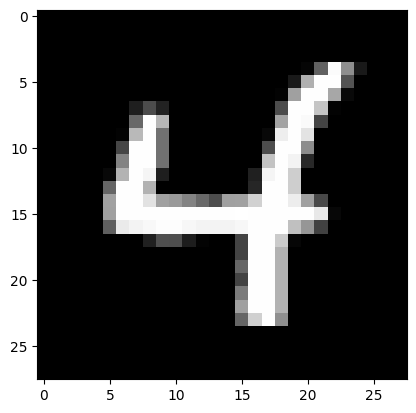

Prediction:  4


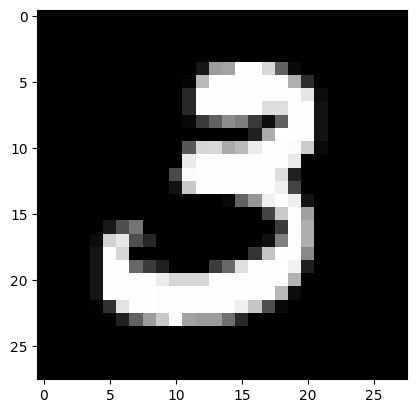

Prediction:  3


In [33]:

training(params, x_train_arr, y_train_arr, alpha, batch_size, epochs)

#Randomly picking 5 digits
for i in range(5):
    show_random_image(params, x_test_arr)

# **Evaluating with Confusion Matrix** 

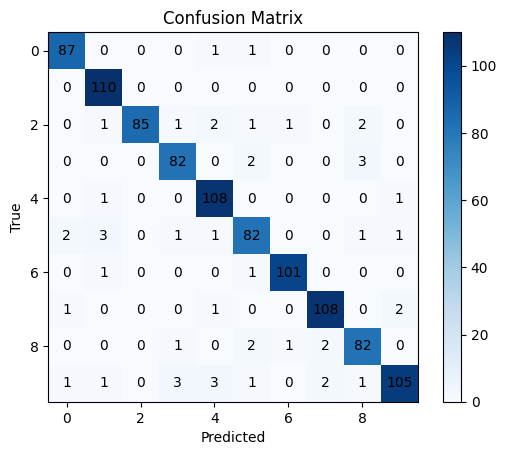

In [34]:
#Confusion matrix
#Run forward prop 1000 times on random train images
sample_size = 1000
random_indices = np.random.choice(len(x_train_arr), size=sample_size, replace=False)
x_random = x_train_arr[random_indices]
y_random = y_train_arr[random_indices]
A2, *_ = forward_prop(params, x_random)
predicted = get_labels(A2)

conf_matrix = np.histogram2d(y_random, predicted, bins=(10, 10))[0].astype(int)

#plot confusion matrix visualizing frequencies
fig, ax = plt.subplots()
im = ax.imshow(conf_matrix, cmap="Blues")

#add colorbar
plt.colorbar(im)

# annotate each cell with its value
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(j, i, conf_matrix[i, j],
                ha="center", va="center", color="black")

ax.set_xlabel("Predicted")
ax.set_ylabel("True")
plt.title("Confusion Matrix")
plt.show()